- `conda activate mri`
  - (created in `0_setup.ipynb`)

---

- `jupyter lab` => open this file

---

- Selected Jupyter default kernel (`ms_classification`)

---

---

# definitions

In [1]:
import glob
import os
import datetime
import numpy as np
import random
# from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import albumentations as A
# from albumentations.core.transforms_interface import ImageOnlyTransform
import itertools

import util

run_id = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
day = run_id = datetime.datetime.now().strftime("%Y%m%d")

2025-05-03 11:40:01.737137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746294002.169524 2269042 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746294002.328339 2269042 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-03 11:40:03.169831: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/uufs/chpc.utah.edu/common/home/u0740821/miniconda3/envs/ms_classification/lib/python3.9/site-packages/albumentations

# Scan Folders Containing Grayscale Slice Files

## Get Baseline Scans

In [2]:
matching_dirs = [d for d in glob.glob(os.path.expanduser('~/dissertation/data/MRI/_[MH]*/*'), recursive=True) if os.path.isdir(d)]

slice_folders_ms_isbi_ph3_test = [x for x in matching_dirs if '_MS__ISBI_3T_test' in x]
# slice_folders_ms_isbi_ph3_train = [x for x in matching_dirs if '_MS__ISBI_3T_train' in x]
# slice_folders_ms_muslim_15t = [x for x in matching_dirs if '_MS__Muslim_et_al_15T' in x]

slice_folders_healthy_ph3 = [x for x in matching_dirs if '_Healthy__IXI_3T' in x]
# slice_folders_healthy_ph15 = [x for x in matching_dirs if '_Healthy__IXI_15T_Guys' in x]
# slice_folders_healthy_ge15 = [x for x in matching_dirs if '_Healthy__IXI_15T_IOP' in x]

# variant_scans = {'baseline': slice_folders_healthy_ph3 + slice_folders_ms_isbi_ph3_train}
# variant_scans = {'baseline': slice_folders_healthy_ph3 + slice_folders_ms_isbi_ph3_test}

# print(f'slice_folders_ms_isbi_ph3_test\n----------\nNumber of scans: {len(slice_folders_ms_isbi_ph3_test)}\nNumber of slices: {len(slice_folders_ms_isbi_ph3_test) * 43}')
# print(f"Actual # slices:  {len(list(itertools.chain(*[glob.glob(os.path.join(folder, '*.png')) for folder in slice_folders_ms_isbi_ph3_test])))}\n\n")

# print(f'slice_folders_ms_isbi_ph3_train\n----------\nNumber of scans: {len(slice_folders_ms_isbi_ph3_train)}\nNumber of slices: {len(slice_folders_ms_isbi_ph3_train) * 43}')
# print(f"Actual # slices:  {len(list(itertools.chain(*[glob.glob(os.path.join(folder, '*.png')) for folder in slice_folders_ms_isbi_ph3_train])))}\n\n")

# print(f'slice_folders_ms_muslim_15t\n----------\nNumber of scans: {len(slice_folders_ms_muslim_15t)}\nNumber of slices: {len(slice_folders_ms_muslim_15t) * 43}')
# print(f"Actual # slices:  {len(list(itertools.chain(*[glob.glob(os.path.join(folder, '*.png')) for folder in slice_folders_ms_muslim_15t])))}\n\n")

# print(f'slice_folders_healthy_ph3\n----------\nNumber of scans: {len(slice_folders_healthy_ph3)}\nNumber of slices: {len(slice_folders_healthy_ph3) * 43}')
# print(f"Actual # slices:  {len(list(itertools.chain(*[glob.glob(os.path.join(folder, '*.png')) for folder in slice_folders_healthy_ph3])))}\n\n")

# print(f'slice_folders_healthy_ph15\n----------\nNumber of scans: {len(slice_folders_healthy_ph15)}\nNumber of slices: {len(slice_folders_healthy_ph15) * 43}')
# print(f"Actual # slices:  {len(list(itertools.chain(*[glob.glob(os.path.join(folder, '*.png')) for folder in slice_folders_healthy_ph15])))}\n\n")

# print(f'slice_folders_healthy_ge15\n----------\nNumber of scans: {len(slice_folders_healthy_ge15)}\nNumber of slices: {len(slice_folders_healthy_ge15) * 43}')
# print(f"Actual # slices:  {len(list(itertools.chain(*[glob.glob(os.path.join(folder, '*.png')) for folder in slice_folders_healthy_ge15])))}\n\n")

## Get Variant Scans

In [3]:
# def get_corresponding_var_scans_from_baseline_scans(baseline_scan_dirs, var_scan_dirs):
#     corresponding_scans = []
#     for path in baseline_scan_dirs:
#         ds, scn = path.split('/')[-2], path.split('/')[-1]
#         # comprehension to cause error/stop if not all 
#         # baseline train scans have corresponding var scan
#         corresponding_var_scan = [x for x in var_scan_dirs if os.path.join(ds, scn) in x][0]
#         corresponding_scans.append(corresponding_var_scan)
#     return corresponding_scans

In [4]:
# for variant in glob.glob('_[bc]*/'):
#     variant = variant.replace('/', '')
#     variant_scans[variant] = glob.glob(os.path.join(variant, '_[MH]*/*'))


# Show Scans

In [5]:
# for v, s in variant_scans.items():
#     print(f"----------\n{v:<20} => Number of scans: " + 
#           f"{len(s)} - Number of slices: {len(s) * 43} - " + 
#           f"Actual # slices:  {len(list(itertools.chain(*[glob.glob(os.path.join(folder, '*.png')) for folder in s])))}")

# Training and Validation Split

## MS:Healthy 1:1

In [6]:
# Seeds/determinism for reproducibility
util.set_seeds()

ms_scan_folders = ([
    # *slice_folders_ms_muslim_15t,
    # *slice_folders_ms_isbi_ph3_train,
    *slice_folders_ms_isbi_ph3_test
])

healthy_scan_folders = [
    *slice_folders_healthy_ph3,
    # *slice_folders_healthy_ph15,
    # *slice_folders_healthy_ge15
]

# Determine the size of the smaller class (MS or Healthy)
min_class_size = min(len(ms_scan_folders), len(healthy_scan_folders))

# shuffle randomly with reproducible seed
random.shuffle(ms_scan_folders)
random.shuffle(healthy_scan_folders)

# Create a balanced training set with equal numbers of MS and healthy samples
train_ms = ms_scan_folders[:min_class_size]
train_healthy = healthy_scan_folders[:min_class_size]
train_scan_folders = train_ms + train_healthy
train_scan_labels = [1] * len(train_ms) + [0] * len(train_healthy)

for v, s in zip(['MS', 'Healthy'], [train_ms, train_healthy]):
    print(f"----------\n{v:<20} => Number of scans: " + 
          f"{len(s)} - Number of slices: {len(s) * 43} - " + 
          f"Actual # slices:  {len(list(itertools.chain(*[glob.glob(os.path.join(folder, '*.png')) for folder in s])))}")

----------
MS                   => Number of scans: 61 - Number of slices: 2623 - Actual # slices:  2623
----------
Healthy              => Number of scans: 61 - Number of slices: 2623 - Actual # slices:  2623


## Extras (undersampling -> Balanced 1:1) => Used in Test

In [7]:
#
# NOTE: these will only have one class (either MS or Healthy)
#       per downsampled to get 1:1 MS:Healhty (extras for now)
#
extra_scans = ms_scan_folders[min_class_size:] + healthy_scan_folders[min_class_size:]
extra_labels = [1] * len(ms_scan_folders[min_class_size:]) + [0] * len(healthy_scan_folders[min_class_size:])

more_healthy_scans = len(ms_scan_folders) < len(healthy_scan_folders)
print('extra','Healthy' if more_healthy_scans else 'MS','scans:',len(extra_scans))

extra Healthy scans: 121


## Train/Val Split

In [8]:
train_scans, val_scans, train_labels, val_labels = train_test_split(
    train_scan_folders,
    train_scan_labels,
    test_size=0.18,
    random_state=util.SEED,
    stratify=train_scan_labels ## stratify ensures train/test remain as close to class distribution as possible (made 1:1 by under-sampling above)
)

print(f"Training set: {sum([x==1 for x in train_labels])} MS, {sum([x==0 for x in train_labels])} Healthy")
print(f"Validation set: {sum([x==1 for x in val_labels])} MS, {sum([x==0 for x in val_labels])} Healthy")

Training set: 50 MS, 50 Healthy
Validation set: 11 MS, 11 Healthy


## Train/Val/Extra - Write CSV's   

In [9]:
def write_csv(name, files, labels):
    with open(f'{name}.csv', 'w') as f:
        f.write('y,folder\n')
        for x, y in list(zip(files, labels)):
            f.write(f'{y},{x}\n')

write_csv(f'train-{day}', train_scans, train_labels)
write_csv(f'val-{day}', val_scans, val_labels)
write_csv(f'extra-{day}', extra_scans, extra_labels)

# Definition: `create_model`

In [10]:
def create_model(input_shape):
    inputs = Input(shape=input_shape)

    # First Conv Block
    x = layers.Conv2D(filters=50, kernel_size=(11, 11), strides=4, activation=None, name='conv1')(inputs)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.Activation('relu', name='relu1')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, name='pool1')(x)

    # Second Conv Block
    x = layers.Conv2D(filters=256, kernel_size=(5, 5), strides=1, activation=None, name='conv2')(x)
    x = layers.BatchNormalization(name='bn2')(x)
    x = layers.Activation('relu', name='relu2')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, name='pool2')(x)

    # Third Conv Block
    x = layers.Conv2D(filters=512, kernel_size=(3, 3), strides=1, activation=None, name='conv3')(x)
    x = layers.BatchNormalization(name='bn3')(x)
    x = layers.Activation('relu', name='relu3')(x)

    # Fourth Conv Block
    x = layers.Conv2D(filters=1024, kernel_size=(2, 2), strides=1, activation=None, name='conv4')(x)
    x = layers.BatchNormalization(name='bn4')(x)

    # Dropout for regularization (to reduce overfitting)
    x_dropout = layers.Dropout(0.5, name='dropout_conv4')(x)   

    # Fifth Conv Block 
    #    (spatially resolved classification head)
    x_logits = layers.Conv2D(filters=2, kernel_size=(1, 1), strides=1, activation=None, name='conv_logits')(x_dropout)
    x_logits = layers.BatchNormalization(name='bn_logits')(x_logits)
    
    # Pool logits to form classification output:
    logits = layers.GlobalMaxPooling2D(name='logits')(x_logits)          # logits: (batch_size, 2)
    
    # Predictions (softmax):
    predictions = layers.Activation('softmax', name='softmax')(logits)   # Output shape: (batch_size, 2)
    
    # Final model clearly defined:
    model = Model(inputs=inputs, outputs=predictions, name='cnn_model')
    return model

# Augmentation Pipeline

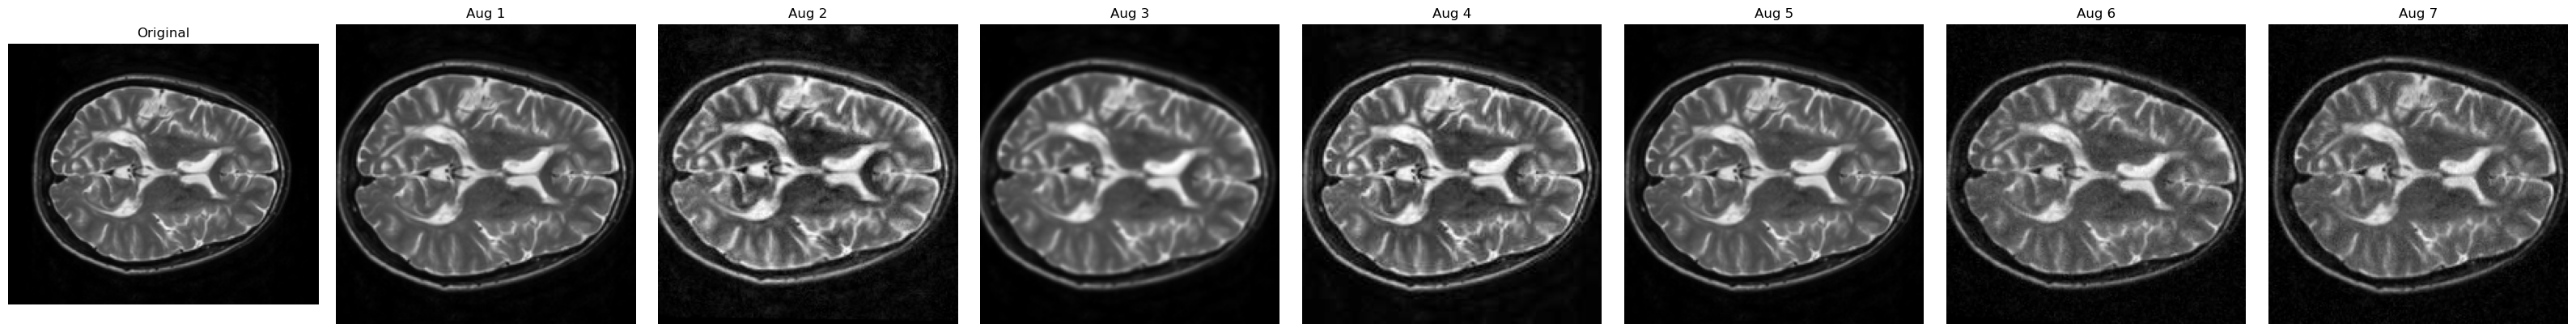

In [11]:
def get_mri_augmentation_pipeline(crop_size):
    
#     if variant == 3:              # "Normalize & Anti-Cheat" Pipeline -- Goal: Normalize away intensity and scanner artifacts so model has to rely on internal features (like lesions).
#         return A.Compose([
#             A.OneOf([
#                 A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
#                 A.RandomGamma(gamma_limit=(80, 120)),
#                 A.CLAHE(clip_limit=2.0),
#             ], p=0.5),
        
#             # Add slight Gaussian smoothing or JPEG compression to degrade non-biological artifacts
#             A.OneOf([
#                 A.GaussianBlur(blur_limit=(3, 5)),
#                 A.ImageCompression(quality_lower=50, quality_upper=80),
#             ], p=0.3),
        
#             # Add noise to remove scanner-specific sharpness/focus cues
#             A.GaussNoise(var_limit=(0.0005, 0.002), p=0.3),
        
#             # Mild shifts to prevent model memorizing skull shape or padding
#             A.ShiftScaleRotate(
#                 shift_limit=0.02, scale_limit=0.03, rotate_limit=5,
#                 border_mode=0, p=0.3
#             ),
        
#             A.CenterCrop(height=crop_size[0], width=crop_size[1], p=1.0),
#         ])                                                                  ###### NOTE: seed was missing for reproducibility





    # "Normalize & Anti-Cheat" Pipeline -- Goal: Normalize away intensity and scanner artifacts so model has to rely on internal features (like lesions).
    return A.Compose([
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
            A.RandomGamma(gamma_limit=(80, 120)),
            A.CLAHE(clip_limit=2.0),
        ], p=0.5),

        # Add slight Gaussian smoothing or JPEG compression to degrade non-biological artifacts
        A.OneOf([
            A.GaussianBlur(blur_limit=(3, 5)),
            A.ImageCompression(quality_lower=50, quality_upper=80),
        ], p=0.3),

        # Add noise to remove scanner-specific sharpness/focus cues
        A.GaussNoise(var_limit=(0.0005, 0.002), p=0.3),

        # Mild shifts to prevent model memorizing skull shape or padding
        A.ShiftScaleRotate(
            shift_limit=0.02, scale_limit=0.03, rotate_limit=5,
            border_mode=0, p=0.3
        ),

        A.CenterCrop(height=crop_size[0], width=crop_size[1], p=1.0),
    ], seed=util.SEED)                                                               ###### NOTE: seed was missing for reproducibility

# Helper function to apply augmentations
def apply_augmentation(augmentation_pipeline, image):
    augmented = augmentation_pipeline(image=image)
    return augmented["image"]

def visualize_random_augmentations(image, transform, n=3, cmap='gray'):
    """Visualize `n` random applications of a transform on a grayscale image."""
    fig, axs = plt.subplots(1, n + 1, figsize=(4 * (n + 1), 4))
    
    # Show original
    axs[0].imshow(image, cmap=cmap)
    axs[0].set_title("Original")
    axs[0].axis('off')
    
    # Apply transform n times
    for i in range(n):
        augmented = transform(image=image)["image"]
        axs[i + 1].imshow(augmented, cmap=cmap)
        axs[i + 1].set_title(f'Aug {i + 1}')
        axs[i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

image = util.load_2d_array_from_slice_png('_MS__ISBI_3T_train/02_04/slice_099.png')
visualize_random_augmentations(image, get_mri_augmentation_pipeline(crop_size=(192, 192)), n=7)

# Definition: `create_dataset`

In [12]:
# Define the TensorFlow Dataset creation function
def create_dataset(slices, labels, augment, augmentation_pipeline, batch_size):        
    def preprocess(image, label):
        image = tf.ensure_shape(image, [None, None])  # Ensure input shape is known

        # Convert TensorFlow tensor to NumPy for Albumentations
        image = image.numpy()

        if augment:
            image = apply_augmentation(augmentation_pipeline, image)

        # Ensure grayscale images have a channel dimension before resizing
        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=-1)

        # Resize even training images that are (192, 192) from cropping to mirror impact
        #   from interpolation that will occur in deployment where resize will occur.
        image = tf.convert_to_tensor(image, dtype=tf.float32)  # Convert back to tensor
        image = tf.image.resize(image, (192, 192), method=tf.image.ResizeMethod.BILINEAR)
        
        image = util.min_max_normalize(image)  # Normalize values to [0, 1]
        image = tf.ensure_shape(image, [192, 192, 1])  # Enforce correct shape

        return image, label

    def tf_preprocess(image, label):
        image, label = tf.py_function(preprocess, [image, label], [tf.float32, tf.int32])
        image.set_shape([192, 192, 1])  # Set static shape
        label.set_shape([])  # Ensure label shape
        return image, label

    dataset = tf.data.Dataset.from_tensor_slices((slices, labels))
    if augment:
        dataset = dataset.shuffle(buffer_size=10000, seed=util.SEED)
    dataset = dataset.map(tf_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Training

In [13]:
import sys

# Suppress TensorFlow logs and outputs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TF logs
tf.get_logger().setLevel('ERROR')         # Suppress further warnings

mod_best_accs = []

batch_size = 32

for variant in ['baseline',
                # '_blurred_SD1', 
                # '_blurred_SD2', 
                # '_blurred_SD3', 
                # '_blurred_SD4', 
                # '_contrast_adapthisteq', 
                # '_contrast_histeq', 
                # '_contrast_imadjust'
               ]:
    # Seeds/determinism for reproducibility
    util.set_seeds()      

    # get augmentation pipeline
    augmentation_pipeline = get_mri_augmentation_pipeline(crop_size=(192, 192))
    
    # load slices/labels
    train_slices, train_labels_array = util.load_slices_from_dir_and_label_lists(train_scans, train_labels)
    val_slices, val_labels_array = util.load_slices_from_dir_and_label_lists(val_scans, val_labels)

    train_labels_array = train_labels_array.astype(np.int32)
    val_labels_array = val_labels_array.astype(np.int32)

     # leave train slices as uint8 per expected by augmentation pipeline
    train_slices = train_slices.astype(np.uint8)
    val_slices = val_slices.astype(np.float32)

    # Create training and validation datasets
    train_dataset = create_dataset(train_slices, 
                                   train_labels_array, 
                                   augment=True, 
                                   augmentation_pipeline=augmentation_pipeline, 
                                   batch_size=batch_size)
    val_dataset = create_dataset(val_slices,
                                 val_labels_array, 
                                 augment=False,
                                 augmentation_pipeline=None,
                                 batch_size=batch_size)

    
    
    
    
    # Model setup
    input_shape = (192, 192, 1)
    suff = f'{variant}_'

    
    
    
    # checkpoint_name = f'best_model__{suff}.keras'
    checkpoint_name = f'best_model__{suff}_{run_id}.keras'


    
    
    
    # get model
    model = create_model(input_shape)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Callbacks
    checkpoint = ModelCheckpoint(checkpoint_name, save_best_only=True, monitor="val_loss")
    early_stopping = EarlyStopping(monitor="val_loss", patience=10)
    def cosine_decay_lr(epoch):
        lr = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=1e-3, decay_steps=50)(epoch)
        return float(lr.numpy())  # Convert the Tensor to a float
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(cosine_decay_lr)

    # Suppress output during training
    with util.NoOutput():
        # Training
        model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=50,
            callbacks=[checkpoint, early_stopping, reduce_lr],
            # verbose=0
            verbose=1                                         ######## changed this to see how many epochs we're dealing with
        )

        # Load the best model
        model.load_weights(checkpoint_name)

        # Evaluate best model
        best_train_acc = model.evaluate(train_dataset, verbose=0)[1]
        best_val_acc = model.evaluate(val_dataset, verbose=0)[1]
        best_accs = f"Model {checkpoint_name}: \nBest Train Acc = {best_train_acc:.4f}, \nBest Validation Acc = {best_val_acc:.4f}"
        with open('train.log', "a") as file:
            file.write(f"{best_accs}\n")
        mod_best_accs.append(best_accs)#print(best_accs)



for accs in mod_best_accs:
    print(accs, '\n------------')

I0000 00:00:1746294035.902870 2269042 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
E0000 00:00:1746294044.699151 2269042 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cnn_model_1/dropout_conv4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1746294045.586829 2269145 cuda_dnn.cc:529] Loaded cuDNN version 90300
W0000 00:00:1746294065.927350 2269042 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 2080 Ti" frequency: 1545 num_cores: 68 environment { key: "architecture" value: "7.5" } environment { key: "cuda" va

Model best_model__baseline__20250503.keras: 
Best Train Acc = 0.9993, 
Best Validation Acc = 0.9926 
------------


# GPU

In [14]:
!nvidia-smi

Sat May  3 11:49:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  |   00000000:3B:00.0 Off |                  N/A |
| 29%   43C    P0             63W /  250W |    9788MiB /  11264MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----